In [1]:
import warnings

warnings.filterwarnings("ignore")

# Learning goals
After today's lesson you should be able to:
- Use cross-validation
- Find the best model for classification and regression problems based on tuning hyperparameters and calculating performance scores

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from pysal.lib import weights

import contextily


## 0.1 Import the data

For this exercise, let's use the San Diego AirBnB data set again. As a reminder: This dataset contains house intrinsic characteristics, both continuous (number of beds as in `beds`) and categorical (type of renting or, in Airbnb jargon, property group as in the series of `pg_X` binary variables), but also variables that explicitly refer to the location and spatial configuration of the dataset (e.g., distance to Balboa Park, `d2balboa` or neighborhood id, `neighborhood_cleansed`).


Our aim here is to make two kinds of predictions: 
- **`log_price`** (Regression): We want to use other features to predict the log(Price) of each airbnb
- **`coastal`** (Classification): We also want to use our features to see if we can predict whether an Airbnb is coastal. 

In [3]:
db = gpd.read_file("https://www.dropbox.com/s/zkucu7jf1xug869/regression_db.geojson?dl=1")


In [4]:
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6110 entries, 0 to 6109
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   accommodates        6110 non-null   int64   
 1   bathrooms           6110 non-null   float64 
 2   bedrooms            6110 non-null   float64 
 3   beds                6110 non-null   float64 
 4   neighborhood        6110 non-null   object  
 5   pool                6110 non-null   int64   
 6   d2balboa            6110 non-null   float64 
 7   coastal             6110 non-null   int64   
 8   price               6110 non-null   float64 
 9   log_price           6110 non-null   float64 
 10  id                  6110 non-null   int64   
 11  pg_Apartment        6110 non-null   int64   
 12  pg_Condominium      6110 non-null   int64   
 13  pg_House            6110 non-null   int64   
 14  pg_Other            6110 non-null   int64   
 15  pg_Townhouse        6110 non-n

In [5]:
db.head()

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,id,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,6,0,0,1,0,0,1,0,0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,5570,0,1,0,0,0,1,0,0,POINT (-117.25253 32.78421)
2,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,9553,1,0,0,0,0,0,1,0,POINT (-117.14121 32.75327)
3,2,1.0,1.0,1.0,Mira Mesa,0,22.293757,0,72.0,4.276666,14668,0,0,1,0,0,0,1,0,POINT (-117.15269 32.93110)
4,2,1.0,1.0,1.0,Roseville,0,6.829451,0,55.0,4.007333,38245,0,0,1,0,0,0,1,0,POINT (-117.21870 32.74202)


Again, notice here that we have: 
- **Discrete variables** (number of bedrooms, beds, baths)
- **Dummy variables** (whether there is a pool, whether near the coast, room type)

# 1. `log_price`
Let's start off with predicting the price of the Airbnb. 


In [6]:
y = db['log_price']

## We'll make our X, independent variables, the "kitchen sink" of all of our other variables for now. 
## I'm using all the variables we have available with the exception of `neighborhood`, which we have to turn into dummy variables in a second. 

X = db[['accommodates', 'bathrooms', 'bedrooms', 'beds', 'pool',
       'd2balboa', 'coastal', 'pg_Apartment',
       'pg_Condominium', 'pg_House', 'pg_Other', 'pg_Townhouse',
       'rt_Entire_home/apt', 'rt_Private_room', 'rt_Shared_room']]

## 1.1 Feature engineering
Feature engineering is the process of creating new variables from the ones you already have. Common feature engineering tasks include:
- Creating dummy variables from categorical variables
- Creating interaction terms between variables
- Creating polynomial terms from variables
- Creating log or square root terms from variables
- Creating lagged variables from time series data or lagged spatial variables 


In [7]:
neighborhood_dummies = pd.get_dummies(db['neighborhood'])

In [8]:
neighborhood_dummies.head()

,Balboa Park,Bay Ho,Bay Park,Carmel Valley,City Heights West,Clairemont Mesa,College Area,Core,Cortez Hill,Del Mar Heights,...,Park West,Rancho Bernadino,Rancho Penasquitos,Roseville,San Carlos,Scripps Ranch,Serra Mesa,South Park,University City,West University Heights
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [9]:
## Here, I want to concatenate my X and neighborhood_dummies into one dataframe.
## I need to tell pd.concat() to either add new columns (axis=1) or add new rows (axis=0).
## The default is axis=0, ie new rows, so I need to specify axis=1.
X = pd.concat([X, neighborhood_dummies],axis=1)

In [10]:
X.head()

,accommodates,bathrooms,bedrooms,beds,pool,d2balboa,coastal,pg_Apartment,pg_Condominium,pg_House,...,Park West,Rancho Bernadino,Rancho Penasquitos,Roseville,San Carlos,Scripps Ranch,Serra Mesa,South Park,University City,West University Heights
0,5,2.0,2.0,2.0,0,2.972077,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,6,1.0,2.0,4.0,0,11.501385,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1.0,1.0,1.0,0,2.493893,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,1.0,1.0,1.0,0,22.293757,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2,1.0,1.0,1.0,0,6.829451,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


Let's also create a new column that is the KNN spatial lag for the 'neighborhood context'. Here, I'm going to use the columns: 
- `pool`, which is a binary (0,1) variable for whether the airbnb has a pool
- `pg_House` which is a binary (0,1) variable for whether the airbnb is a house

I will choose K=20, to give me the 20 closest neighboring Airbnbs. My spatial lag should be a number between 0 and 20 to estimate, of the 20 closest Airbnb, how many have pools and how many are other housees.

In [11]:
knn = weights.KNN.from_dataframe(db, k=20)

In [12]:
pool_lag = weights.lag_spatial(knn, db['pool'])
house_lag = weights.lag_spatial(knn, db['pg_House'])

The chart below shows that neighboring airbnbs mostly don't have a pool. 

(array([3060.,  889.,  580.,  437.,  259.,  241.,  221.,  118.,  121.,
         184.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

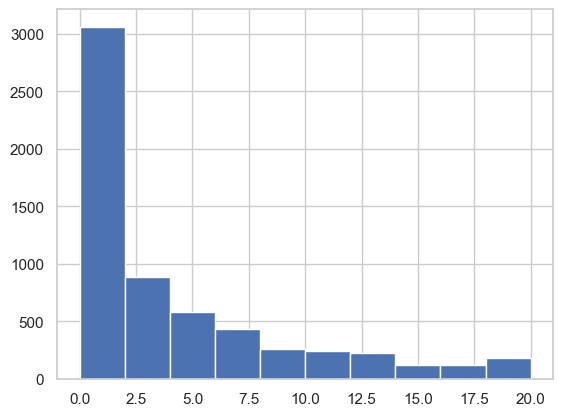

In [13]:
plt.hist(pool_lag)

But there are a lot more neighborinng Airbnbs that are houses. 

(array([792., 485., 701., 813., 767., 727., 713., 527., 372., 213.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

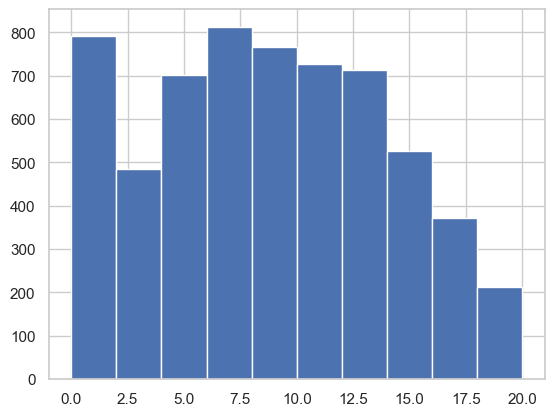

In [14]:
plt.hist(house_lag)

Add these to new features to our original data. 

In [15]:
X['pool_lag'] = pool_lag
X['house_lag'] = house_lag


## 1.1 Create our Train-Test Split
We almost always start off with splitting our data into our **train** and **test** sets. 

In [16]:
from sklearn.model_selection import train_test_split

## Let's use the default split for now, which is 75-25 train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,)


## 1.2 Predict the data
Here, let's use a decision tree regressor to predict the price. 

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error



In [18]:
model = DecisionTreeRegressor()

model.fit(X_train, y_train)

DecisionTreeRegressor()

## 1.3 Cross-validation
Now we use the k-fold cross-validation method is run our model several times on different parts of the training data. 

In [19]:
## The default scoring metric for Random Forest is R^2, so we can use cross_val_score() to get the R^2 for each fold.
scores = cross_val_score(model, X_train, y_train, cv=5)
scores

array([0.40140386, 0.55646846, 0.42657876, 0.45233723, 0.46177053])

As you can see, there is some variation here. 

In [20]:
scores.mean()

0.4597117656549548

Our average R^2 is about 45.5%. 

## 1.4 Test score 
Let's see how well our model does on the test data. 

In [21]:
# evaluate the model on the second set of data
ypred_rf = model.predict(X_test)
print("R^2 is:", r2_score(y_test, ypred_rf))
print("Mean absolute error is:", mean_absolute_error(y_test, ypred_rf))
print("Mean squared error is:", mean_squared_error(y_test, ypred_rf))

R^2 is: 0.47409960275507756
Mean absolute error is: 0.41791511556422195
Mean squared error is: 0.3360272869897668


So the model performed slightly worse - 49% - on the test set. 

## 1.5 Tuning our hyperparameters

### 1.5.1 Tweaking our trees
Let's say we think to get a better score, we need to maximum tree depth. Let's test this. 

In [22]:
trees = np.linspace(1,20,20).astype(int)
trees

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

The below might take a bit of time to run. (uff it took 3 minutes and 14 seconds for me!)

In [24]:
%%time
## Let's create an empty list to hold our scores
mean_scores_train = []
mean_scores_test = []

## Now, let's loop through our trees and get the mean score for each
for t in trees: 
    model = DecisionTreeRegressor(max_depth=int(t))
    model.fit(X_train, y_train)
    scores_train = cross_val_score(model, X_train, y_train, cv=5)
    
    ypred_rf = model.predict(X_test)
    score_test = r2_score(y_test, ypred_rf)

    mean_scores_train.append(scores_train.mean())
    mean_scores_test.append(score_test)



CPU times: user 1.58 s, sys: 19.8 ms, total: 1.6 s
Wall time: 1.85 s


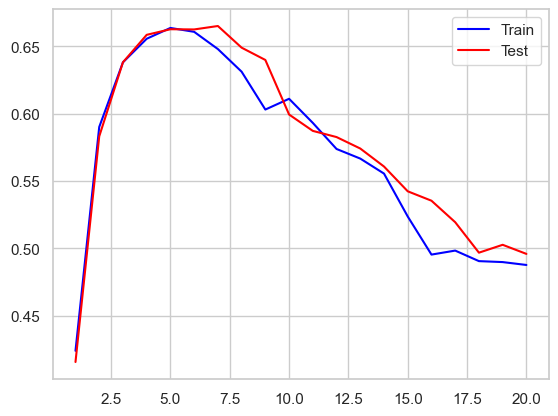

In [25]:
plt.plot(trees,mean_scores_train,color='blue',label='Train')
plt.plot(trees,mean_scores_test,color='red',label='Test')
plt.legend()

Two insights emerge: 
1. Setting a maximum depth generally produced better scores than the default of not setting any depth (just letting the tree split until each leaf is "pure", i.e. contains values of the same category). 
2. We can see from this that after about a 5 maximum depth, our performance starts to decrease. 

## 1.6 Grid Search
But what about other parameters? 

`sklearn` has a way of optimizing for all the hyperparameters you'd like to tune. Let's say, here, we want to test the following hyperparatmers. You can see the full list for this algorithm in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html): 
- The loss criterion: `criterion`, which can be {“squared_error”, “friedman_mse”, “absolute_error”, “poisson”}
- The maximum tree depth: `max_depth`
- The minimum number of samples required for the next split: `min_samples_split`

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
              'max_depth': np.linspace(1,20,20).astype(int),
              'min_samples_split': np.linspace(1,100,20).astype(int)}

grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, verbose=1)

~~This might take a while since we're doing 8000 model fits!~~ Don't run this now as it takes 80 minutes. You can try to decrease the 

In [27]:
grid.fit(X, y)

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


KeyboardInterrupt: 

In [28]:
sorted(grid.cv_results_.keys())

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [ ]:
grid.best_params_

`grid.best_params` got me `{'criterion': 'poisson', 'max_depth': 6, 'min_samples_split': 89}`

## Q.1 Classification
Instead of predicting the log price, now instead predict whether an AirBnB is coastal. Using the same steps (feature engineering, train-test split, cross-validation, hyperparameter tuning) as above, **select one hyperparameter** to optimize for a classification model. It doesn't have to be a Decision Tree! (10 pts)

In [40]:
from sklearn.gaussian_process import GaussianProcessClassifier
# coastal is a categorical variable
y = db['coastal']
X = db[['accommodates', 'bathrooms', 'bedrooms', 'beds', 'pool',
       'd2balboa', 'pg_Apartment',
       'pg_Condominium', 'pg_House', 'pg_Other', 'pg_Townhouse',
       'rt_Entire_home/apt', 'rt_Private_room', 'rt_Shared_room','log_price']]
neighborhood_dummies = pd.get_dummies(db['neighborhood'])
X = pd.concat([X, neighborhood_dummies], axis=1)
# spatial lag of features
knn = weights.KNN.from_dataframe(db, k=20)
pool_lag = weights.lag_spatial(knn, db['pool'])
house_lag = weights.lag_spatial(knn, db['pg_House'])
X['pool_lag'] = pool_lag
X['house_lag'] = house_lag

# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)
model = GaussianProcessClassifier()
model.fit(X_train, y_train)

GaussianProcessClassifier()

In [41]:
# cross validation
scores = cross_val_score(model, X_train, y_train, cv=5)
scores

array([0.98773006, 0.98568507, 0.98261759, 0.98157625, 0.98874104])

In [42]:
# wow... this is pretty impressive result.
# test score
gaussian_model = model.predict(X_test)
print("R^2 is:", r2_score(y_test, gaussian_model))
print("Mean absolute error is:", mean_absolute_error(y_test, gaussian_model))
print("Mean squared error is:", mean_squared_error(y_test, gaussian_model))
# looks like gaussian process have its own built-in hyperparameter tuning function.

R^2 is: 0.9436138796603913
Mean absolute error is: 0.01309328968903437
Mean squared error is: 0.01309328968903437


In [47]:
# lets try ada boost here
from sklearn.ensemble import AdaBoostClassifier
# coastal is a categorical variable
y = db['coastal']
X = db[['accommodates', 'bathrooms', 'bedrooms', 'beds', 'pool',
       'd2balboa', 'pg_Apartment',
       'pg_Condominium', 'pg_House', 'pg_Other', 'pg_Townhouse',
       'rt_Entire_home/apt', 'rt_Private_room', 'rt_Shared_room','log_price']]
neighborhood_dummies = pd.get_dummies(db['neighborhood'])
X = pd.concat([X, neighborhood_dummies], axis=1)
# spatial lag of features
knn = weights.KNN.from_dataframe(db, k=20)
pool_lag = weights.lag_spatial(knn, db['pool'])
house_lag = weights.lag_spatial(knn, db['pg_House'])
X['pool_lag'] = pool_lag
X['house_lag'] = house_lag

# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)
model = AdaBoostClassifier(n_estimators=2)
model.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=2)

In [48]:
# cross validation
scores = cross_val_score(model, X_train, y_train, cv=5)
scores

array([0.89366053, 0.9202454 , 0.88854806, 0.90174002, 0.88024565])

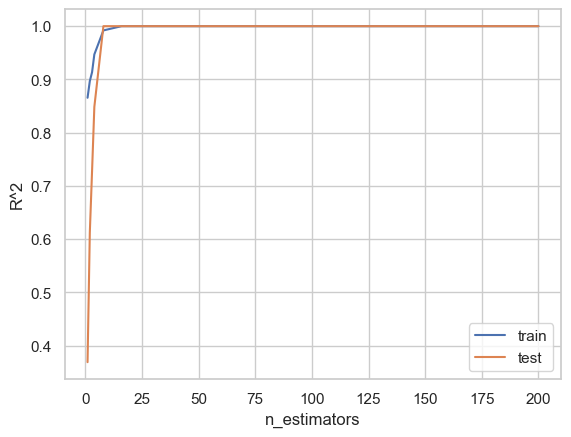

In [49]:
# lets try tuning the n_estimators manually
n_estimators = [1, 2, 3, 4, 8, 16, 32, 64, 100, 200]
mean_scores_train = []
mean_scores_test = []
for n in n_estimators:
    model = AdaBoostClassifier(n_estimators=n)
    model.fit(X_train, y_train)
    scores_train = cross_val_score(model, X_train, y_train, cv=5)
    ypred_rf = model.predict(X_test)
    score_test = r2_score(y_test, ypred_rf)

    mean_scores_train.append(scores_train.mean())
    mean_scores_test.append(score_test)

plt.plot(n_estimators, mean_scores_train, label='train')
plt.plot(n_estimators, mean_scores_test, label='test')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('R^2')
plt.show()


In [50]:
# looks like any n_estimators > 10 works here.
# notice that in case of perfect fit, the learning procedure is stopped early, larger n_estimators will not harm in this example.